<a href="https://colab.research.google.com/github/takemuralab/OAcenter_ai_project/blob/main/kadai_kitakyushu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [37]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
random_seed = 123

In [38]:
url = 'https://ckan.open-governmentdata.org/dataset/876ed829-9dcd-46a7-98d4-c3722886e945/\
resource/6e30e40f-c415-4733-be10-c549c66065b9/download/401005_kitakyushu_covid19_patients_symptom.csv'

df = pd.read_csv(url, encoding='cp932', parse_dates=[0])

display(df.head())

display(df.tail())

,状況_年月日,全国地方公共団体コード,都道府県名,市区町村名,入院等,調整中,入院等・調整中内訳_無症状,入院等・調整中内訳_軽症・中等症,入院等・調整中内訳_重症,入院等・調整中内訳_確認中,退院,死亡,陽性者数_累計
0,2020-06-28,401005,福岡県,北九州市,9,0,0,6,2,1,229,6,244
1,2020-06-29,401005,福岡県,北九州市,10,0,1,6,2,1,229,6,245
2,2020-06-30,401005,福岡県,北九州市,10,0,1,6,2,1,229,6,245
3,2020-07-01,401005,福岡県,北九州市,11,0,1,7,2,1,231,6,248
4,2020-07-02,401005,福岡県,北九州市,10,0,1,6,2,1,232,6,248


,状況_年月日,全国地方公共団体コード,都道府県名,市区町村名,入院等,調整中,入院等・調整中内訳_無症状,入院等・調整中内訳_軽症・中等症,入院等・調整中内訳_重症,入院等・調整中内訳_確認中,退院,死亡,陽性者数_累計
187,2021-01-01,401005,福岡県,北九州市,210,23,42,184,7,0,1079,23,1335
188,2021-01-02,401005,福岡県,北九州市,200,44,43,194,7,0,1085,23,1352
189,2021-01-03,401005,福岡県,北九州市,208,29,38,192,7,0,1112,24,1373
190,2021-01-04,401005,福岡県,北九州市,194,29,34,183,6,0,1145,24,1392
191,2021-01-05,401005,福岡県,北九州市,191,52,36,194,7,6,1168,24,1435


In [39]:
columns = ['日付', '地域コード', '県名', '市名', '入院数', '調整中', '無症状', '軽症_中等症', '重症', '入院調整数', '退院', '志望', '陽性者累計' ]

df.columns = columns

In [40]:
#データの前処理
df2 = df.copy()

# 「日付」「陽性者累計」列の抽出
df2 = df2[['日付', '陽性者累計']]

# 列名の置き換え
df2.columns = ['ds', 'y']

# 結果確認
display(df2.head())
display(df2.tail())


,ds,y
0,2020-06-28,244
1,2020-06-29,245
2,2020-06-30,245
3,2020-07-01,248
4,2020-07-02,248


,ds,y
187,2021-01-01,1335
188,2021-01-02,1352
189,2021-01-03,1373
190,2021-01-04,1392
191,2021-01-05,1435


In [41]:
# 分割日 mdayの設定
mday = pd.to_datetime('2020-12-15')

# 訓練用indexと検証用indexを作る
train_index = df2['ds'] < mday
test_index = df2['ds'] >= mday

# 入力データの分割
x_train = df2[train_index]
x_test = df2[test_index]

# 日付データの分割　（グラフ表示用）
dates_test = df2['ds'][test_index]


In [42]:
# ライブラリのインポート
from fbprophet import Prophet

m1 = Prophet(yearly_seasonality=False, weekly_seasonality=False, 
             daily_seasonality=False, seasonality_mode='multiplicative')

In [43]:
# 学習
m1.fit(x_train)

In [44]:
future1 = m1.make_future_dataframe(periods=90, freq='D')

# 結果確認
display(future1.head())
display(future1.tail())

,ds
0,2020-06-28
1,2020-06-29
2,2020-06-30
3,2020-07-01
4,2020-07-02


,ds
255,2021-03-10
256,2021-03-11
257,2021-03-12
258,2021-03-13
259,2021-03-14


In [45]:
# 予測
# 結果はデータフレームで戻ってくる
fcst1 = m1.predict(future1)

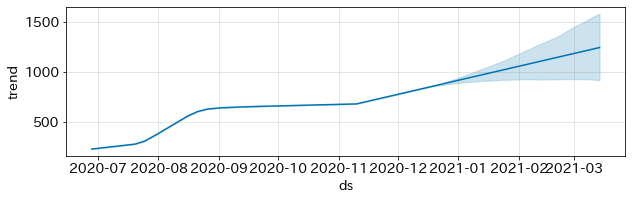

In [46]:
#評価
fig = m1.plot_components(fcst1)
plt.show()

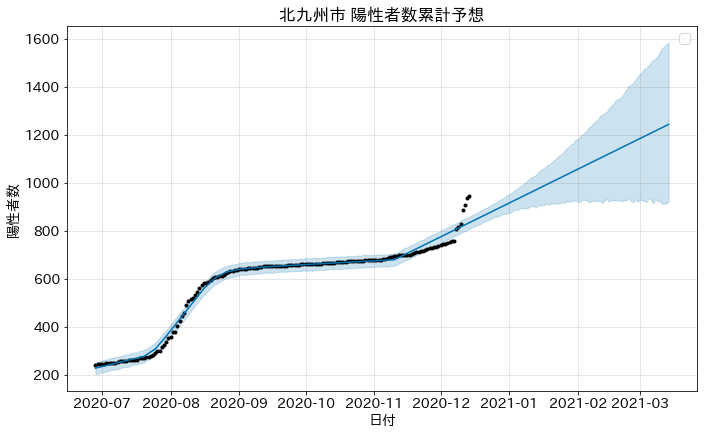

In [51]:
# 訓練データ・検証データ全体のグラフ化
fig, ax = plt.subplots(figsize=(10,6))

# 予測結果のグラフ表示(prophetの関数)
m1.plot(fcst1, ax=ax)

# タイトル設定など
ax.set_title('北九州市 陽性者数累計予想')
ax.set_xlabel('日付')
ax.set_ylabel('陽性者数')

# グラフ表示
plt.show()

In [52]:
# ypred1: fcst1から予測部分のみ抽出する
ypred1 = fcst1[-22:][['yhat']].values

# ytest1: 予測期間中の正解データ
ytest1 = x_test['y'].values


# R2値の計算
from sklearn.metrics import r2_score
score = r2_score(ytest1, ypred1)

# 結果確認
print(f'R2 score:{score:.4f}')

R2 score:0.3795
